tb - 7/8/2022 - Generalizing the data generator for sparse linear regression using stochastic gradient descent. The goal is to select the terms found in [093] using the entire dataset. One of the first steps will be to compare features selected when training on both datasets at once compared to individual (-4K) or (+4K) climates.

# Imports and Initialization

## Imports

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures

from cbrain.cam_constants import *
from cbrain.climate_invariant import *
from cbrain.equation_discovery import *
from cbrain.preprocessing.convert_dataset_20191113 import compute_LHF_nsDELQ
from cbrain.climate_invariant_utils import *
from scipy.integrate import cumtrapz,trapz
from scipy import interpolate,misc

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import xarray as xr

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

## Load data

In [3]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}
climate_str = ['cold','hot','both']
set_str = ['train','valid','test']
test_clim_str = ['cold','hot','both','medium']
path_array['cold'] = [path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_03_18_O3_VALID_M4K.nc',
                      path_data+'2021_03_18_O3_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_03_18_O3_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_03_18_O3_VALID_P4K.nc',
                     path_data+'2021_03_18_O3_TEST_P4K.nc']
path_array['both'] = [path_data+'2022_04_18_TRAIN_M4K_P4K_shuffle.nc',
                      path_data+'2022_04_18_VALID_M4K_P4K.nc',
                      path_data+'2022_04_18_TEST_M4K_P4K.nc']
path_array['medium'] = [path_data+'2021_01_24_O3_TRAIN_shuffle.nc',
                        path_data+'2021_01_24_O3_VALID.nc',
                        path_data+'2021_01_24_O3_TEST.nc']
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

In [4]:
path_RH_B_train = path_data+'2022_07_08_B_RH_TRAIN_both.nc'
path_RH_B_test = path_data+'2022_06_26_B_RH_both.nc'

In [5]:
climates = ['m4K','ref','p4K']
path_append = ['2021_03_18_O3_TEST_M4K.nc','2021_01_24_O3_TEST.nc','2021_03_18_O3_TEST_P4K.nc']
path_RH_B_append = ['2022_06_27_B_RH_TEST_m4K.nc','2022_06_27_B_RH_TEST_ref.nc','2022_06_27_B_RH_TEST_p4K.nc']
path_LHF_nsDELQ = '2022_06_29_LHF_nsDELQ.nc'
path_LHF_nsDELQ_train = '2022_07_08_LHF_nsDELQ_TRAIN_both.nc'

In [6]:
LHF_nsDELQ_train = xr.open_dataset(path_data+path_LHF_nsDELQ_train)
LHF_nsDELQ_test = xr.open_dataset(path_data+path_LHF_nsDELQ)

In [7]:
train_both = xr.open_dataset(path_array['both'][0])
train_both_RH_B = xr.open_dataset(path_RH_B_train)

In [8]:
test_sets = {}; test_sets_RHB = {}; 
LHFname = ['LHFns_cold','LHFns_med','LHFns_hot']

In [9]:
for iclim,clim in enumerate(climates):
    test_sets[clim] = xr.open_dataset(path_data+path_append[iclim])
    test_sets_RHB[clim] = xr.open_dataset(path_data+path_RH_B_append[iclim])

In [10]:
ind_input = np.concatenate((np.arange(0,60),np.arange(90,94)))
ind_output = np.arange(94,94+60)

In [11]:
xt = {}; yt = {}; xRHt= {}; xBt = {}; xLHFnst = {};

In [12]:
name_RH = ['RH_test_cold','RH_test_med','RH_test_hot']
name_B = ['B_test_cold','B_test_med','B_test_hot']

In [13]:
x = train_both['vars'][:,ind_input]
xRH = train_both_RH_B['RH_train']
xB = train_both_RH_B['B_train']
xLHFns = LHF_nsDELQ_train['LHFns']
y = train_both['vars'][:,ind_output]
for iclim,clim in enumerate(climates):
    xt[clim] = test_sets[clim]['vars'][:,ind_input]
    xRHt[clim] = test_sets_RHB[clim][name_RH[iclim]]
    xBt[clim] = test_sets_RHB[clim][name_B[iclim]]
    xLHFnst[clim] = LHF_nsDELQ_test[LHFname[iclim]]
    yt[clim] = test_sets[clim]['vars'][:,ind_output]

# First attempt using least-squared error (no SGD)

In [35]:
Model_Types = ['localBF','localCI','BF','CI']
N_subsample = 5
N_degree = 4
Nsample = 3000

In [36]:
KEYS = {}
KEYS['local'] = ['ps', 'S0', 'SHF', 'LHF','LHFns','p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localCI'] = ['ps', 'S0', 'SHF','LHFns','p','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localBF'] = ['ps', 'S0', 'SHF', 'LHF', 'p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD']
KEYS['all'] = np.concatenate((KEYS['local'],['Q_above','Q_below','T_below','T_above',
                                             'RH_below','RH_above','B_below','B_above']))
KEYS['BF'] = np.concatenate((KEYS['localBF'],['Q_above','Q_below','T_below','T_above']))
KEYS['CI'] = np.concatenate((KEYS['localCI'],['RH_below','RH_above','B_below','B_above']))
scalar_keys = ['ps','S0','SHF','LHF','LHFns']
vector_keys = ['p', 'q', 'dq_dp_FD', 'd2q_dp2_FD', 'Q_above', 'Q_below',
               'T', 'dT_dp_FD', 'd2T_dp2_FD', 'T_above', 'T_below',
               'RH', 'dRH_dp_FD', 'd2RH_dp2_FD', 'RH_above', 'RH_below',
               'B', 'dB_dp_FD', 'd2B_dp2_FD', 'B_above', 'B_below']
combin_keys = np.concatenate((scalar_keys,vector_keys))

In [37]:
min_features = [1,1,1,1,1]
max_features = [11,6,6,6,6]
cv = [2,2,2,2,2]

In [38]:
dict_Q = {}; dict_T = {};

## Second attempt, this time using both the cold and the warm parts of the dataset

In [ ]:
for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    # Pre-process & sub-sample the data
    i_random = np.random.choice(np.linspace(0,xt[clim].shape[0]-1,xt[clim].shape[0]),
                                size=((Nsample,)),replace=False).astype('int')
    dict_Q[i_subsample]['Selected_indices'] = i_random;
    dict_T[i_subsample]['Selected_indices'] = i_random;
    
    x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,variables=KEYS['all'])
    x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_keys,vector_keys)
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,y_train,scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dQdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dTdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_07_18_dicQT_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))

## First attempt only using the cold part of the dataset (once again)

In [ ]:
for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    # Pre-process & sub-sample the data
    i_random = np.random.choice(np.linspace(0,xt[clim].shape[0]-1,xt[clim].shape[0]),
                                size=((Nsample,)),replace=False).astype('int')
    dict_Q[i_subsample]['Selected_indices'] = i_random;
    dict_T[i_subsample]['Selected_indices'] = i_random;
    
    x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,
                                               xt,yt,xRHt,xBt,xLHFnst,hyam,hybm,
                                               KEYS['all'])
    x_train_range,x_test_range,Norm = range_normalizer(x_train,x_test,scalar_keys,vector_keys)
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,x_test_range,
                     y_train,y_test,scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
            X_test_poly = {};
            for iclim,clim in enumerate(climates):
                X_test_poly[clim] = poly.fit_transform(X_test[clim])
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,X_test_poly,
                     dQdt_train,dQdt_test,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,X_test_poly,
                     dTdt_train,dTdt_test,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_07_12_dicQT_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))

In [ ]:
# save_path = path_data+'Polynomial_Fits/2022_07_12_dicQT_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
# pickle.dump({
#   "Qfits": dict_Q[i_subsample][model_type],
#   "Tfits": dict_T[i_subsample][model_type],
#   'Selected_indices': i_random}, open(save_path,'wb'))

# Second attempt using the full dataset and terms selected by the SFS

## Load most important features calculated using subsamples of the training set

To redo using models trained on *both* climates

In [85]:
path_Poly = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/Polynomial_Fits/'

In [86]:
tmp = pickle.load(open(path_Poly+'2022_07_22_Terms_Count.pkl','rb'))

In [87]:
termQ = tmp['Terms_Moisture']
termT = tmp['Terms_Temperature']

In [88]:
Models = ['localBF','localCI','BF','CI']

## Visualization of terms selected most often

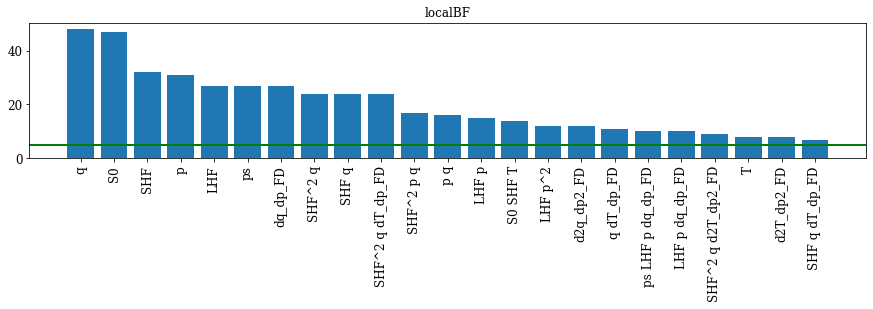

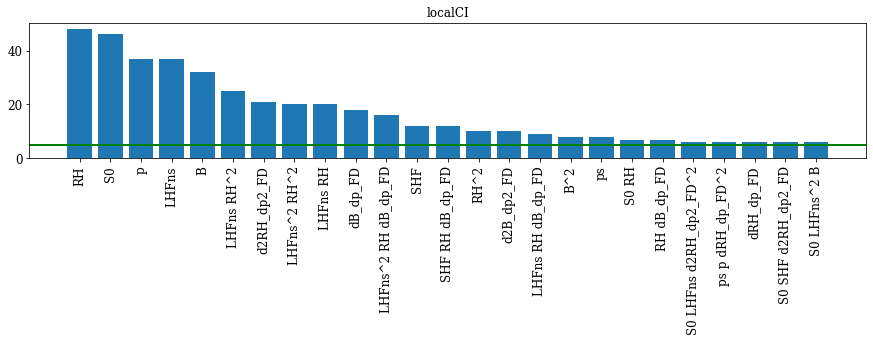

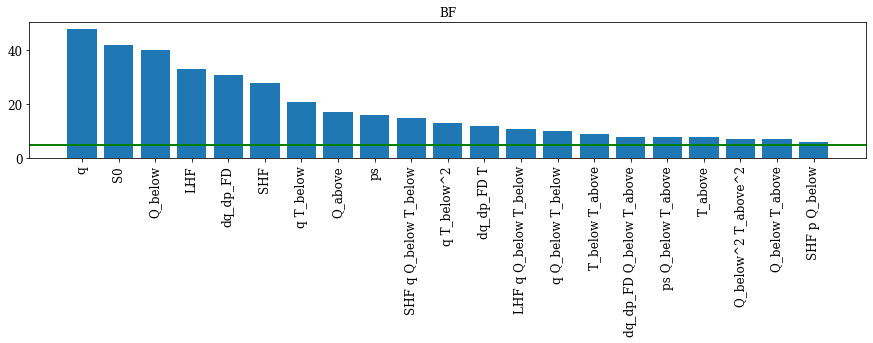

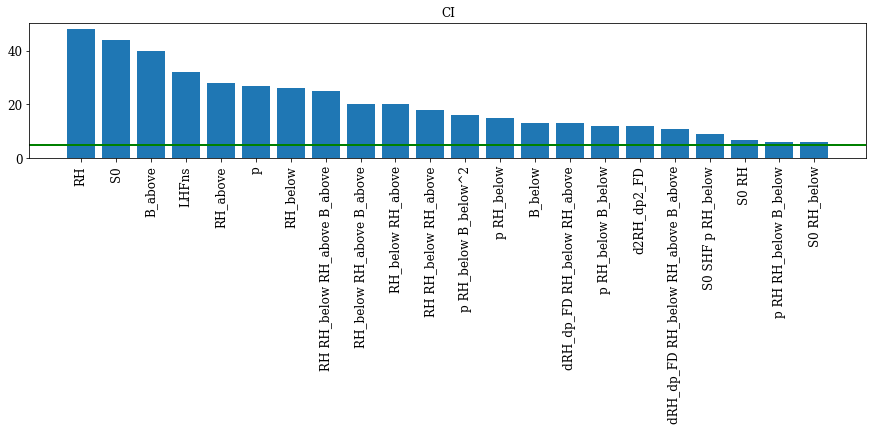

In [83]:
term = termT

for i in range(4):
    fig, ax = plt.subplots(1,1,figsize=(15,2.5))
    plt.bar(term[Models[i]]['variables'][term[Models[i]]['count']>5],
              term[Models[i]]['count'][term[Models[i]]['count']>5])
    plt.axhline(y=5,color='g')
    plt.xticks(rotation=90);
    plt.xticks(fontsize=fz);
    plt.title(Models[i],fontsize=fz)

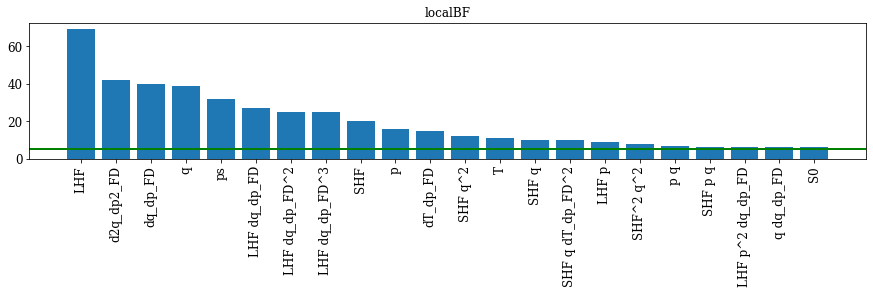

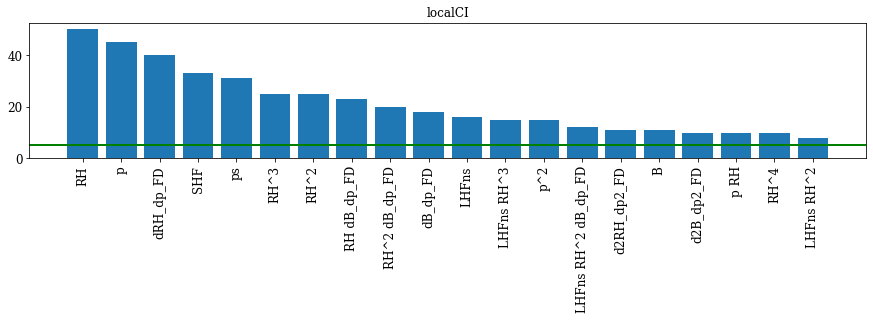

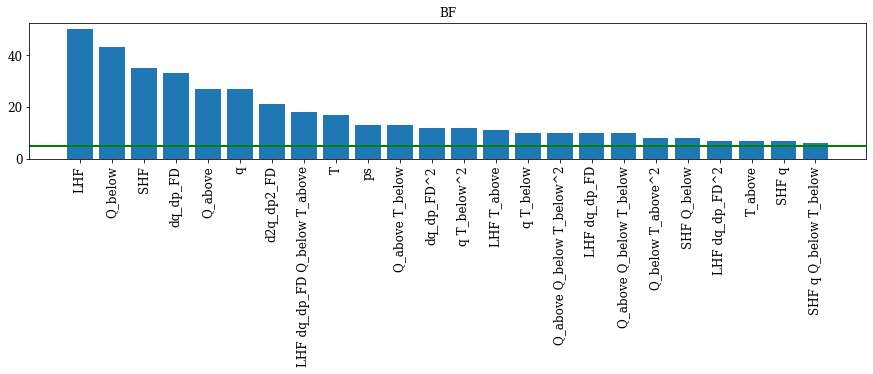

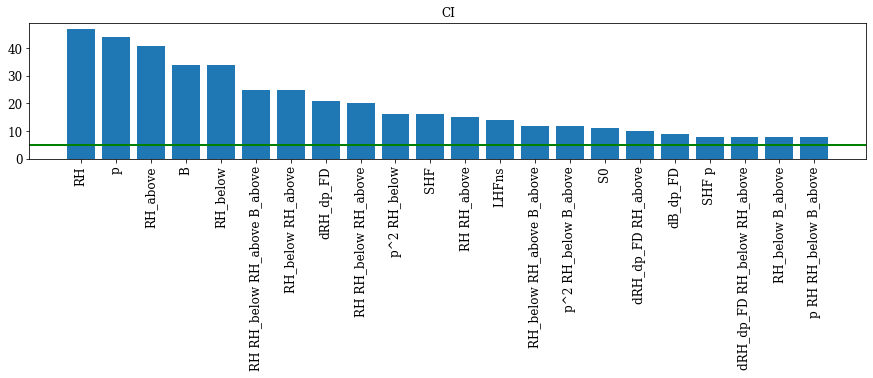

In [19]:
term = termQ

for i in range(4):
    fig, ax = plt.subplots(1,1,figsize=(15,2.5))
    plt.bar(term[Models[i]]['variables'][term[Models[i]]['count']>5],
              term[Models[i]]['count'][term[Models[i]]['count']>5])
    plt.axhline(y=5,color='g')
    plt.xticks(rotation=90);
    plt.xticks(fontsize=fz);
    plt.title(Models[i],fontsize=fz)

## Train model on larger portion of the dataset using the top selected features

### Prototype: LocalBF for subgrid moistening

In [20]:
model = 'localBF'

In [90]:
#terms = termQ[model]['variables'][termQ[model]['count']>5]
terms = termQ[model]['variables']

In [91]:
terms

array(['LHF', 'd2q_dp2_FD', 'dq_dp_FD', 'q', 'ps', 'LHF dq_dp_FD',
       'LHF dq_dp_FD^2', 'LHF dq_dp_FD^3', 'SHF', 'p', 'dT_dp_FD',
       'SHF q^2', 'T', 'SHF q', 'SHF q dT_dp_FD^2', 'LHF p', 'SHF^2 q^2',
       'p q', 'SHF p q', 'LHF p^2 dq_dp_FD', 'q dq_dp_FD', 'S0',
       'SHF p q d2T_dp2_FD', 'd2T_dp2_FD', 'SHF q dT_dp_FD',
       'SHF q dq_dp_FD^2', '1', 'SHF q^2 dq_dp_FD', 'LHF p q',
       'dq_dp_FD^2', 'SHF q dq_dp_FD', 'LHF p^3', 'LHF p dq_dp_FD^2',
       'LHF q dT_dp_FD', 'LHF p dT_dp_FD^2', 'q dT_dp_FD',
       'LHF d2q_dp2_FD^2', 'SHF p^2 q', 'q dq_dp_FD^2', 'p^2 q',
       'SHF p q dq_dp_FD', 'LHF p T', 'LHF p dq_dp_FD T'], dtype='<U18')

Find "base terms" and "base polynomials" that appear in the selected terms

In [92]:
unique_terms = []; unique_pol = [];
for term in terms:
    for t in term.split():
        po = t.find('^')
        if po>0: unique_terms.append(t[:po])
        else: unique_terms.append(t)
        unique_pol.append(t)
unique_terms = list(set(unique_terms))
unique_pol = list(set(unique_pol))

In [93]:
unique_terms

['SHF',
 'ps',
 'dq_dp_FD',
 'd2q_dp2_FD',
 'dT_dp_FD',
 'S0',
 '1',
 'q',
 'p',
 'T',
 'LHF',
 'd2T_dp2_FD']

Problem in current implementation of FD if a second derivative term appears without its first derivative counterpart

In [94]:
unique_pol # Not used in algorithm's current form

['SHF',
 'p^2',
 'ps',
 'dq_dp_FD',
 'd2q_dp2_FD',
 'dT_dp_FD',
 'S0',
 '1',
 'q',
 'p',
 'T',
 'LHF',
 'd2T_dp2_FD',
 'dq_dp_FD^2',
 'q^2',
 'p^3',
 'dT_dp_FD^2',
 'SHF^2',
 'd2q_dp2_FD^2',
 'dq_dp_FD^3']

In [114]:
Nsample = 3000

In [115]:
dictest = {}

In [116]:
# Pre-process & sub-sample the data
i_random = np.random.choice(np.linspace(0,x.shape[0]-1,x.shape[0]),
                            size=((Nsample,)),replace=False).astype('int')
dictest['Selected_indices'] = i_random;

In [117]:
x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,unique_terms)

In [118]:
scalar_sel = list(set(scalar_keys)&set(unique_terms))
vector_sel = list(set(vector_keys)&set(unique_terms))
combin_sel = np.concatenate((scalar_sel,vector_sel))

Load pre-calculated normalization statistics

In [119]:
save_name = path_data+'2022_07_22_NORM_PDF_CDF_TRAIN_BOTH_M4K_P4K'

In [120]:
tmp = pickle.load(open(save_name,'rb'))

In [121]:
Norm = {}
Norm['mean'] = {}
Norm['min'] = {}
Norm['max'] = {}
Norm['std'] = {}
for keys in combin_keys:
    Norm['mean'][keys] = tmp['MEAN'][keys]
    Norm['min'][keys] = tmp['MIN'][keys]
    Norm['max'][keys] = tmp['MAX'][keys]
    Norm['std'][keys] = tmp['STD'][keys]    

In [122]:
x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_sel,vector_sel,Norm=Norm)

Now add the polynomial terms (note that unique_pol is not used at this point)

In [123]:
pol_to_add = list(set(terms).difference(set(unique_terms)))

In [124]:
for key in pol_to_add:
    x_train_range[key] = x_train_range[unique_terms[0]]**0
    for t in key.split():
        po = t.find('^')
        if po>0: x_train_range[key] *= x_train_range[t[:po]]**int(t[po+1:])
        else: x_train_range[key] *= x_train_range[t]

Transform dictionary into tensor for regression purposes

In [125]:
term0 = list(set(terms).difference('1'))

In [126]:
X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
dic_to_array(term0,x_train_range,y_train,scale_dict)

In [127]:
X_train.shape

(90000, 42)

In [128]:
# Linear regression on polynomial features - dQ/dt & dT/dt
dictest = SFS_poly(term0,X_train,dQdt_train,1,10,2)

{'LHF dq_dp_FD^3': 372.23613576646153, 'LR_Bias': -7.9983635351366, 'mse_train': 1362.0522656966918} 

{'SHF^2 q^2': -417.37250019221227, 'LHF dq_dp_FD^3': 485.321234957744, 'LR_Bias': -9.516316832880094, 'mse_train': 1355.5012446398348} 

{'SHF^2 q^2': -679.9613409339897, 'LHF dq_dp_FD': -261.8076084155158, 'LHF dq_dp_FD^3': 1407.675720468238, 'LR_Bias': -5.200229996003636, 'mse_train': 1342.1396256566727} 

{'LHF p q': 214.67203557354142, 'SHF^2 q^2': -1549.8943624715318, 'LHF dq_dp_FD': -217.26364811363104, 'LHF dq_dp_FD^3': 1120.5385461031437, 'LR_Bias': -4.234901093391984, 'mse_train': 1335.0476865324433} 

{'LHF q dT_dp_FD': -2283.7292770321988, 'LHF p q': 1729.60386918659, 'SHF^2 q^2': -1585.3648747003845, 'LHF dq_dp_FD': -298.46885917873374, 'LHF dq_dp_FD^3': 1598.1414891866882, 'LR_Bias': -5.148809645032536, 'mse_train': 1308.0129437066107} 

{'LHF q dT_dp_FD': -2064.7801348171197, 'LHF p q': 1660.420123684191, 'SHF^2 q^2': -821.0471612137717, 'LHF dq_dp_FD': -430.222951864511

Surprised that the fit is not better - repeating the previous implementation of SFS+polynomial fit for comparison

In [ ]:
x_train2,x_test2,y_train2,y_test2 = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,variables=KEYS['all'])

In [ ]:
Norm = {}
Norm['mean'] = {}
Norm['min'] = {}
Norm['max'] = {}
Norm['std'] = {}
for keys in KEYS['all']:
    Norm['mean'][keys] = tmp['MEAN'][keys]
    Norm['min'][keys] = tmp['MIN'][keys]
    Norm['max'][keys] = tmp['MAX'][keys]
    Norm['std'][keys] = tmp['STD'][keys]    

In [ ]:
x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_sel,vector_sel,Norm=Norm)

### Generalize to all models for both subgrid heating/moistening

# Fit-the-CDF method

## Calculate the empirical CDF of the main variables

In [ ]:
x.shape

In [ ]:
Nsample = 2500000

In [ ]:
i_random = np.random.choice(np.linspace(0,xt[clim].shape[0]-1,xt[clim].shape[0]),
                                size=((Nsample,)),replace=False).astype('int')

In [ ]:
x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,variables=KEYS['all'])

In [ ]:
combin_keys = np.concatenate((scalar_keys,vector_keys))

In [ ]:
def edg2bin(edges):
    return (edges[:-1]+edges[1:])/2

In [ ]:
PDF = {}; EDG = {}; CDF = {}; MAX = {}; MIN = {};

In [ ]:
PDF = {}; EDG = {}; CDF = {}; MAX = {}; MIN = {}; MEAN = {}; STD = {}

In [ ]:
for k in x_train.keys():
    print(k)
    PDF[k],EDG[k] = np.histogram(x_train[k].flatten(),bins=250,density=True)
    db = np.array(np.diff(EDG[k]), float)  
    CDF[k] = db*PDF[k].cumsum()
    MAX[k] = np.max(x_train[k].flatten())
    MIN[k] = np.min(x_train[k].flatten())
    MEAN[k] = np.mean(x_train[k].flatten())
    STD[k] = np.std(x_train[k].flatten())

Save the CDFs to fit them in an independent notebook

In [ ]:
save_name = path_data+'2022_07_22_NORM_PDF_CDF_TRAIN_BOTH_M4K_P4K'

In [ ]:
#pickle.dump({"PDF":PDF,"CDF":CDF,"EDG":EDG,"MAX":MAX,"MIN":MIN,"MEAN":MEAN,"STD":STD}, open(save_name,'wb'))

In [ ]:
plt.plot(edg2bin(EDG['T_above']),CDF['T_above'])

In [ ]:
cumtrapz(x=edg2bin(EDG['T']),y=PDF['T'],initial=0).shape

In [ ]:
def cdf_q(x):
    
    from scipy.special import erf
    
    def acosh_abs(x):
        return np.arccosh(np.abs(x)+1e-8+1)
    
    return erf(np.arctan(np.tanh(acosh_abs(x) * 8.828)))

In [ ]:
def cdf_dqdt(x):
    
    def relu(x):
        return x*(x>0)
    
    return (relu(x -2*6.0664007e-9) / np.maximum(x,1e-10))

In [ ]:
test = cdf_q(x_train['q'])

In [ ]:
test2 = cdf_dqdt(x_train['dq_dp_FD'])

## Include the CDF transform as optional variables when sub-sampling

In [ ]:
def CDF_keys(x0,key):
    
    from scipy.special import erfc
    from scipy.special import gamma
    from scipy.special import erf
    
    def relu(x):
        return x*(x>0)

    def log10_abs(x):
        return np.log10(np.abs(x)+1e-8)

    def cos(x):
        return np.cos(x)

    def acosh_abs(x):
        return np.arccosh(np.abs(x)+1e-8+1)

    def asinh(x):
        return np.arcsinh(x)

    def cube(x):
        return x**3

    def square(x):
        return x**2

    def tanh(x):
        return np.tanh(x)

    def tan(x):
        return np.tan(x)

    def sin(x):
        return np.sin(x)

    def sinh(x):
        return np.sinh(x)

    def exp(x):
        return np.exp(x)

    def atan(x):
        return np.arctan(x)
    
    if key=='p': cdf = atan((x0 * 1e-5) + 0.15) # Retained third candidate
    elif key=='q': cdf = erf(atan(tanh(acosh_abs(x0) * 8.828))) # Retained last candidate
    elif key=='T': cdf = ((sinh(log10_abs(x0))-4.6766) * 0.813) # Retained last candidate that didn't ReLU neg T
    elif key=='RH': cdf = cos((x0*0.7456)-1.45) # Keeps monotonically increasing property of CDF
    elif key=='B': cdf = (atan(exp(x0 / acosh_abs(x0)))-0.0214) # Has the best CDF properties
    elif key=='S0': cdf = erf(x0* 0.000438 + 0.212) # Pretty "easy" CDF
    elif key=='ps': cdf = erf(cube(tan(x0 * 1e-4))) # Has better monotonicity properties, but not valid at high ps
    elif key=='SHF': cdf = relu(tanh((x0 + 1.965) * 0.05))
    elif key=='LHF': cdf = tanh(relu((x0 + 13.2) * 0.0096))
    elif key=='LHFns': cdf = square(erfc(erfc(asinh((x0 / 0.011873) + 0.023746))))
        
    return np.maximum(0,np.minimum(1,cdf))

In [ ]:
Model_Types = ['localBF_CDF','BF_CDF','localBF','localCI_CDF','CI_CDF','localCI']
N_subsample = 5
N_degree = 3
Nsample = 3000

KEYS = {}
KEYS['local'] = ['ps', 'S0', 'SHF', 'LHF','LHFns','p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localCI'] = ['ps', 'S0', 'SHF','LHFns','p','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localBF'] = ['ps', 'S0', 'SHF', 'LHF', 'p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD']
KEYS['all'] = np.concatenate((KEYS['local'],['Q_above','Q_below','T_below','T_above',
                                             'RH_below','RH_above','B_below','B_above']))
KEYS['BF'] = np.concatenate((KEYS['localBF'],['Q_above','Q_below','T_below','T_above']))
KEYS['CI'] = np.concatenate((KEYS['localCI'],['RH_below','RH_above','B_below','B_above']))
scalar_keys = ['ps','S0','SHF','LHF','LHFns']
vector_keys = ['p', 'q', 'dq_dp_FD', 'd2q_dp2_FD', 'Q_above', 'Q_below',
               'T', 'dT_dp_FD', 'd2T_dp2_FD', 'T_above', 'T_below',
               'RH', 'dRH_dp_FD', 'd2RH_dp2_FD', 'RH_above', 'RH_below',
               'B', 'dB_dp_FD', 'd2B_dp2_FD', 'B_above', 'B_below']
combin_keys = np.concatenate((scalar_keys,vector_keys))
KEYS['CDF_vector'] = ['p','q','T','RH','B']
KEYS['CDF_scalar'] = ['S0','ps','SHF','LHF','LHFns']
KEYS['CDF'] = np.concatenate((KEYS['CDF_vector'],KEYS['CDF_scalar']))
for k in KEYS['CDF_scalar']:
    scalar_keys = np.concatenate((scalar_keys,['CDF_'+k]))
for k in KEYS['CDF_vector']:
    vector_keys = np.concatenate((vector_keys,['CDF_'+k,'dCDF_'+k+'dp_FD','d2CDF_'+k+'dp2_FD']))
combin_keys = np.concatenate((scalar_keys,vector_keys))
KEYS['BF_CDF'] = ['CDF_S0', 'CDF_ps', 'CDF_SHF', 'CDF_LHF','CDF_p','CDF_q', 'dCDF_qdp_FD',
                  'd2CDF_qdp2_FD', 'CDF_T', 'dCDF_Tdp_FD','d2CDF_Tdp2_FD']
KEYS['localBF_CDF'] = np.concatenate((KEYS['localBF'],KEYS['BF_CDF']))
KEYS['CI_CDF'] = ['CDF_S0', 'CDF_ps', 'CDF_SHF', 'CDF_LHFns',
                  'CDF_p','CDF_RH','dCDF_RHdp_FD', 'd2CDF_RHdp2_FD',
                  'CDF_B', 'dCDF_Bdp_FD','d2CDF_Bdp2_FD']
KEYS['localCI_CDF'] = np.concatenate((KEYS['localCI'],KEYS['CI_CDF']))

min_features = [1,1,1,1,1]
max_features = [11,6,6,6,6]
cv = [2,2,2,2,2]

dict_Q = {}; dict_T = {};

In [ ]:
## Second attempt, this time using both the cold and the warm parts of the dataset

for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    # Pre-process & sub-sample the data
    i_random = np.random.choice(np.linspace(0,xt[clim].shape[0]-1,xt[clim].shape[0]),
                                size=((Nsample,)),replace=False).astype('int')
    dict_Q[i_subsample]['Selected_indices'] = i_random;
    dict_T[i_subsample]['Selected_indices'] = i_random;
    
    x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,variables=KEYS['all'])
    for k in KEYS['CDF']:
        x_train['CDF_'+k] = CDF_keys(x_train[k],k)
        if k in KEYS['CDF_vector']:
            x_train['dCDF_'+k+'dp_FD'] = p_derivative(x_train['CDF_'+k],x_train['p'])
            x_train['d2CDF_'+k+'dp2_FD'] = p_derivative(x_train['dCDF_'+k+'dp_FD'],x_train['p'])
    x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_keys,vector_keys)
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,y_train,scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dQdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dTdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_07_19_dicCDF_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))
